# Quantum Amplitude Estimation (QAE) in combination with QSVT

We employ QSVT to solve a linear system and QAE to extract a single amplitude of the the QSVT solution.

In [1]:
# import python libraries
import numpy as np 
import pennylane as qml
import pennylane.templates as qmlt
import matplotlib.pyplot as plt
import math
from itertools import combinations

# import self-written routines
from routines.bin_dec_conversion import bin2dec, dec2bin
from routines.QSVT import qsvt_ls_pyqsp, plot_poly_pyqsp

# Define linear system

In [2]:
A = np.array(
    [
        [0.65713691, -0.05349524, 0.08024556, -0.07242864],
        [-0.05349524, 0.65713691, -0.07242864, 0.08024556],
        [0.08024556, -0.07242864, 0.65713691, -0.05349524],
        [-0.07242864, 0.08024556, -0.05349524, 0.65713691],
    ]
)

b = np.array([1, 2, 3, 4], dtype="complex")
target_x = np.linalg.inv(A) @ b  # true solution

# Normalize states:
norm_b = np.linalg.norm(b)
b = b / norm_b

norm_x = np.linalg.norm(target_x)
normalized_x = target_x / norm_x

# Choose phase angles for QSVT

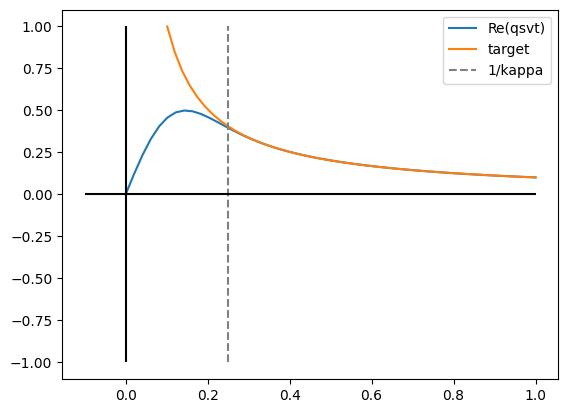

In [3]:
s_pyqsp = 0.10145775
phi_pyqsp = [-1.5922142770532273, -0.03252949895974533, 0.06067372571024077, 0.3119249700528526, 0.21643648192810572, -0.6257675633866073, 2.2647603713275712, -2.9452302836036406, 0.7351754207364953, 0.2758836177105888, -0.11643337976620094, 0.649573162685275, 0.12829303551227234, -1.0892339063760752, 2.3144971667719467, -2.6272826402282705, -0.21949773265116868, 2.6389896276979274, -2.2213989345063783, 2.6543450662205297, -0.17021410564966066, -2.1307099378221315, 1.01088271573515, -0.17021410582656094, -0.487247587299507, 0.9201937191031345, -0.5026030261033417, -0.2194977327290849, 0.5143100130364344, -0.8270954871909815, 2.052358747478442, -3.0132996176161053, 0.6495731628695878, -0.11643337963853151, 0.27588361797184735, 0.7351754206492971, 0.19636236921530748, -0.8768322826914424, -0.6257675629979345, 0.21643648227708767, 0.31192496995906427, 0.06067372558084472, -0.03252949895439006, -0.0214179502139501]
plot_poly_pyqsp(phi_pyqsp, s_pyqsp, kappa=4)

ancilla_qsvt_size = 1

In [4]:
# Solve linear system using QSVT

wires = np.arange(ancilla_qsvt_size+3).tolist()

dev = qml.device("default.qubit", wires=wires)
@qml.qnode(dev)
def test_qsvt():
    qsvt_ls_pyqsp(A, b, phi_pyqsp, wires) 

    return qml.state()

qsvt_state = test_qsvt()[:2**2].real

# Define Grover operator for QAE
$Q = -AS_0A^\dagger S_\psi$

In [5]:
def grover_op_list(A, b, phi, wires, psi):
    ops = []
    ops.append(qml.FlipSign([0]*ancilla_qsvt_size + [0] + psi, wires=wires))    # S_psi
    ops.append(qml.adjoint(qsvt_ls_pyqsp)(A, b, phi, wires))                    # A^dagger
    ops.append(qml.FlipSign([0]*ancilla_qsvt_size + [0, 0, 0], wires=wires))    # S_0
    ops.append(qsvt_ls_pyqsp(A, b, phi, wires))                                 # A
    ops.append(qml.GlobalPhase(np.pi, wires=wires))                             # -1

    return ops

class grover_operator(qml.operation.Operation):
    def __init__(self, A, b, phi, wires, psi, id=None):
        super().__init__(wires=wires, id=id)
        self.A = A
        self.b = b
        self.phi = phi
        self.psi = psi

    def decomposition(self):
        # Define the sequence of operations that make up the custom operation
        return grover_op_list(self.A, self.b, self.phi, self.wires, self.psi)

# Define QAE circuit with QSVT inside

In [6]:
def qae_circuit(A, b, phi, wires, qae_phase_size, amplitude=[0, 0]):
    # prepare state by qsvt routine
    qsvt_ls_pyqsp(A, b, phi, wires[qae_phase_size:])

    # apply Hadamard gates on phase register
    for wire in wires[:qae_phase_size]:
        qml.Hadamard(wires=wire)

    # apply controlled sequence of Grover operators (containing qsvt)
    qml.ControlledSequence(grover_operator(A, b, phi, wires=wires[qae_phase_size:], psi=amplitude), control=wires[:qae_phase_size])
    
    # apply Inverse Fourier Transform on phase register
    qml.adjoint(qml.QFT)(wires=wires[:qae_phase_size])

# Run QAE
We solve now our linear system of equations using QSVT and apply QAE to extract the first amplitude of the solution state.
Hence, psi is set to |00>.

In [7]:
psi = [1, 1]

qae_phase_size = 5
block_size = 1
solution_size = 2

wires = np.arange(qae_phase_size+ancilla_qsvt_size+block_size+solution_size)
dev = qml.device("default.qubit", wires=wires)

@qml.qnode(dev)
def qae_qsvt(A, b, phi, psi):
    qae_circuit(A, b, phi, wires, qae_phase_size, psi)
    return qml.probs(wires=wires[:qae_phase_size])


In [8]:
print(qml.draw(qae_qsvt)(A, b, phi_pyqsp, psi))

0: ──H─────────────╭●──────────────────╭QFT†─┤ ╭Probs
1: ──H─────────────├●──────────────────├QFT†─┤ ├Probs
2: ──H─────────────├●──────────────────├QFT†─┤ ├Probs
3: ──H─────────────├●──────────────────├QFT†─┤ ├Probs
4: ──H─────────────├●──────────────────╰QFT†─┤ ╰Probs
5: ─╭qsvt_ls_pyqsp─├ControlledSequence───────┤       
6: ─├qsvt_ls_pyqsp─├ControlledSequence───────┤       
7: ─├qsvt_ls_pyqsp─├ControlledSequence───────┤       
8: ─╰qsvt_ls_pyqsp─╰ControlledSequence───────┤       


In [9]:
def psi2int(psi):
    binn = ""
    for i in psi:
        binn = f"{binn}{i}"
    
    return int(bin2dec(binn))

Our solution state of QSVT could look like $\ket{x} = c_{00}\ket{00} + c_{01}\ket{01} + c_{10}\ket{10} + c_{11}\ket{11}$. \
If we want to extract $c_{00}$ with QAE ($\ket{\psi}=\ket{00}$), we get some binary number in our QAE phase register $\ket{\theta_{00}}$.\
We can compute $c_{00}$ by using the relation $c_{00} = \sin(\theta_{00}\pi)$.

QAE result: 0.09801714032956083 (0.11111)
QSVT amplitude: 0.11754406725769687 (0.0000100110 or 0.1111011001)


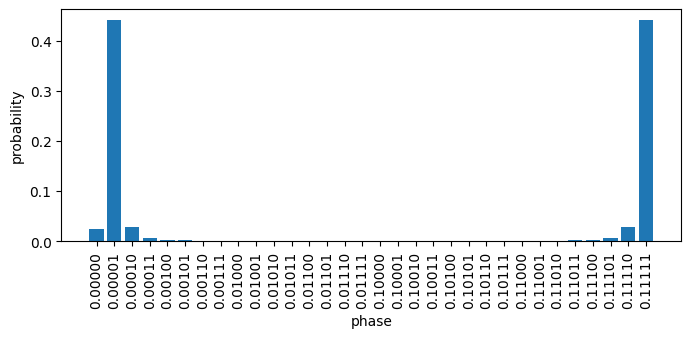

In [10]:
results = qae_qsvt(A, b, phi_pyqsp, psi)

bit_strings = [f"0.{x:0{qae_phase_size}b}" for x in range(len(results))]

plt.figure(figsize=(8, 4))
plt.bar(bit_strings, results)
plt.xlabel("phase")
plt.ylabel("probability")
plt.xticks(rotation="vertical")
plt.subplots_adjust(bottom=0.3)
print(f"QAE result: {np.sin(bin2dec(bit_strings[results.tolist().index(max(results))])*np.pi)} ({bit_strings[results.tolist().index(max(results))]})")
print(f"QSVT amplitude: {qsvt_state[psi2int(psi)]} ({dec2bin(np.arcsin(qsvt_state[psi2int(psi)])/np.pi)} or {dec2bin(1+np.arcsin(-qsvt_state[psi2int(psi)])/np.pi)})")